## Домашнее задание по оптимизации.

 - Прочитать про методы оптимизации для нейронных сетей https://habr.com/post/318970/
 - Реализовать самостоятельно логистическую регрессию
        - Обучить ее методом градиентного спуска
        - Методом nesterov momentum
        - Методом rmsprop

В качестве dataset’а взять Iris, оставив 2 класса:
Iris Versicolor, 
Iris Virginica.


### Подготовительная часть

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

parameters = {
    'axes.labelsize':  14,
    'figure.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'legend.title_fontsize': 14
}
plt.rcParams.update(parameters)

Загружаем требуемый датасет, преобразуем его в Pandas DataFrame, выбираем данные только по требуемым классам.

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

col_names = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
df = pd.DataFrame(data=iris.data, columns=col_names)
 
# Append class / label data
df["class"] = iris.target
df['name'] = iris.target_names[df['class']]
df = df[df['name'].isin(['versicolor', 'virginica'])]

Выбираем столбцы фич и преобразуем их с помощью StandardScaler.

In [3]:
X = df[col_names]
print(X.head())
ss = StandardScaler()
X = ss.fit_transform(X)

    sepal_length  sepal_width  petal_length  petal_width
50           7.0          3.2           4.7          1.4
51           6.4          3.2           4.5          1.5
52           6.9          3.1           4.9          1.5
53           5.5          2.3           4.0          1.3
54           6.5          2.8           4.6          1.5


Перекодируем переменную классов, чтобы она содержала только единицы и нули.

In [4]:
le = LabelEncoder()
le.fit( df['name'] )
df['new_class_code'] = le.transform(df['name'])
y = df['new_class_code']
y.head(), y.tail()

(50    0
 51    0
 52    0
 53    0
 54    0
 Name: new_class_code, dtype: int64,
 145    1
 146    1
 147    1
 148    1
 149    1
 Name: new_class_code, dtype: int64)

Напишем функции необходимые для обучения и оценки качества логистической регрессии.

In [5]:
def sigmoid(z):
    '''Рассчитывает сигмоиду, векторно.'''
    return 1/(1 + np.exp(-z))

def logistic_regression(X, a):
    '''Логистическая регрессия.'''
    return sigmoid(np.dot(X,a))
    # return sigmoid((np.sum(X*a, axis = 1)))

def logistic_classifier(X, a, threshold=0.5):
    '''Классификатор на основе логистической регрессии с порогом по умолчанию 0,5.'''
    to_classify = logistic_regression(X, a)
    return np.where(to_classify >= threshold, 1, 0)
    
def sigmoid_loss(X, y, a):
    '''Функция потерь логистической регрессии.'''
    # loss = - np.sum(y*np.log(logistic_regression(X, a)) + (1-y)*np.log(1-logistic_regression(X, a)))
    loss = (-np.dot(y, np.log(logistic_regression(X, a))) 
           - np.dot((1-y), np.log(1 - logistic_regression(X, a)))
           )
    return loss

def classifier_score(y_pred, y_true):
    '''Оценивает точности классификатора.'''
    return np.sum(y_true == y_pred)/ len(y_true)
    
def classifier_accuracy_matrix(y_pred, y_true):
    '''Строит матрицу точности классификации.'''
    first_class = [
        np.sum((y_pred == 0) & (y_true == 0)),
        np.sum((y_pred == 1) & (y_true == 0))
    ]
    second_class = [
        np.sum((y_pred == 1) & (y_true == 1)),
        np.sum((y_pred == 0) & (y_true == 1))
    ]
    print('             right')
    print('First_class  ', first_class)
    print('Second class ',second_class)

Выберем произвольное начальное приближение для вектора коэффициентов

In [6]:
# a = np.array([-10, 2, 3, 0.4])
a = np.array([0, 0, 0, 0])
print('Loss function value = ', sigmoid_loss(X, y, a))
print('Accuracy_score = ', classifier_score(logistic_classifier(X, a), y))
classifier_accuracy_matrix(logistic_classifier(X, a), y)

Loss function value =  69.31471805599452
Accuracy_score =  0.5
             right
First_class   [0, 50]
Second class  [50, 0]


Функция для вычисления градиента:

In [7]:
def gradient(a0=a, X=X, y=y, f=sigmoid_loss, grad_delta=1e-6):
    """ вычисляет градиент функции f относительно парамтера a """
    grad_vector = np.zeros(len(a0), np.float32)
    grad_mask = np.array([-grad_delta, 0, grad_delta])
    # цикл по компонентам вектора параметров
    # на каждом шаге по трём точкам
    # вычисляется производная по одной из координат
    a0 = np.repeat(a0, 3).reshape(len(a0), 3)
    for i, ai in enumerate(a0):
        mask = np.zeros([len(a), 3], np.float32)
        mask[i] += grad_mask
        # дополняем вектор градиента найденой производной
        grad_vector[i] = np.gradient(f(X, y, mask+a0), grad_delta)[1]
    return grad_vector

### Простой градиентный спуск

In [8]:
def gd(a0=a, X=X, y=y, f=sigmoid_loss, learning_rate= 0.01, grad_delta=1e-12, loss_accuracy=0.01):
    # в этот список будем записывать все значения
    # функции потерь для дальнейшего анализа
    losses = []
    # начальное значение функции потерь
    a0_loss = sigmoid_loss(X, y, a0)
    losses.append(a0_loss)
    # переменная для условия цикла по сходимости
    new_loss = a0_loss + loss_accuracy*10
    
    while abs(a0_loss - new_loss) > loss_accuracy:
        # на каждом шаге запоминаем старое значение функции потерь
        a0_loss = new_loss
        # считаем градиент
        grad_vector = gradient(a0=a0, X=X, y=y, f=f)
        # смещаемся против градиента на learning_rate*grad_vector
        a0 = a0 - learning_rate*grad_vector
        # считем функцию потерь в новой точке
        new_loss = sigmoid_loss(X, y, a0)
        # запоминаем новое значение
        losses.append(new_loss)
    return a0, losses

a_new, gd_losses = gd()
print('New coefficients: ', a_new)
print('Steps:', len(gd_losses))
print('Loss function value = ', gd_losses[-1])
print('Accuracy_score = ', classifier_score(logistic_classifier(X, a_new), y))
classifier_accuracy_matrix(logistic_classifier(X, a_new), y)

New coefficients:  [-0.68253379 -1.05188029  3.53711547  3.82784826]
Steps: 164
Loss function value =  7.688101924752345
Accuracy_score =  0.98
             right
First_class   [49, 1]
Second class  [49, 1]


Обучение логистической регрессии методом градиентного спуска привело к тому, что она смогла верно проклассифицировать все точки, кроме двух.

<ipython-input-5-834b852f1e40>:19: RuntimeWarning: divide by zero encountered in log
  - np.dot((1-y), np.log(1 - logistic_regression(X, a)))


Text(0, 0.5, 'функция потерь')

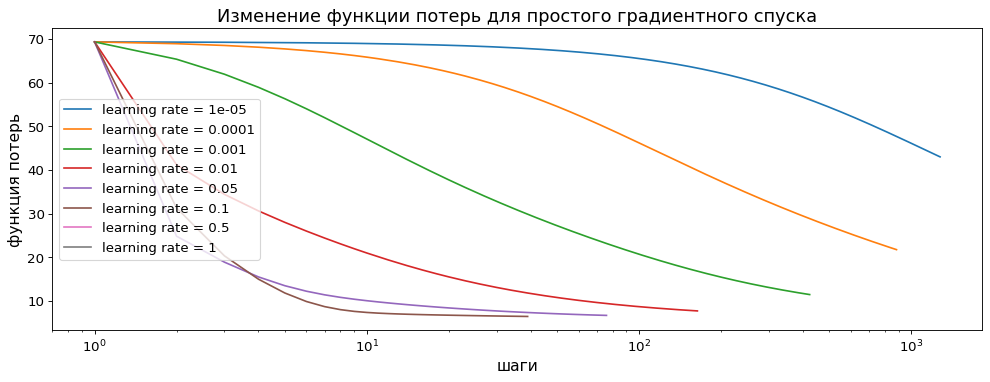

In [9]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для простого градиентного спуска')
for lr in [1e-5, 1e-4,0.001, 0.01, 0.05, 0.1, 0.5, 1]:
    a_new, gd_losses = gd(learning_rate= lr)
    plt.plot(list(range(1, len(gd_losses)+1)), gd_losses, label = 'learning rate = ' + str(lr))
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

При слишком малом значении скорости обучения алгоритм застревает в локальном минимуме, при слишком большом выскакивает за пределы области определения оптимизируемой функции. Также этот алгоритм достигнув окрестностей точки минимума начинает подходить к ней очень медленно.

### nesterov momentum

Дополняет стандартный градиентный спуск "памятью" о том, направлении, в котором спускался на предыдущем шаге.

In [10]:
def gd_nesterov(
        a0=a, X=X, y=y, f=sigmoid_loss, 
        learning_rate= 0.0001, # скорость обучения 
        beta=0.9, # параметр, отвечающий за влияние предыдущего шага спуска на текущий шаг
        grad_delta=1e-12, 
        loss_accuracy=0.01
    ):
    # в этот список будем записывать все значения
    # функции потерь для дальнейшего анализа
    losses = []
    # начальное значение функции потерь    
    a0_loss = sigmoid_loss(X, y, a0)
    losses.append(a0_loss)
    
    # счиатем градиент в начальной точке и делаем 
    # первый шаг такой же, как и при простом градиентном спуске
    grad_vector = gradient(a0=a0, X=X, y=y, f=f)
    # но запоминаем, где мы были на предыдущем шаге
    a0_prev = a0
    a0 = a0 - learning_rate*grad_vector
    
    # переменная для условия цикла по сходимости
    new_loss = a0_loss + loss_accuracy*10
    # переменная для ограничения числа итераций
    steps=0
    while abs(a0_loss - new_loss) > loss_accuracy:
        a0_loss = new_loss
        # смещаем из результата предыдущего шага в старом направлении
        a0_move = beta*(a0 - a0_prev)
        # считаем градиент в смещённой точке
        grad_vector = gradient(a0=a0+a0_move, X=X, y=y, f=f)
        a0_prev = a0
        # из сдвинутой точки смещаемся против градиента
        a0 = a0 + a0_move - learning_rate*grad_vector
        # обновляем значение функции потерь
        new_loss = sigmoid_loss(X, y, a0)
        losses.append(new_loss)
        
        steps += 1
        if steps > 1e3: break
    return a0, losses
    
a_new, gd_losses = gd_nesterov()
print('New coefficients: ', a_new)
print('Steps:', len(gd_losses))
print('Loss function value = ', gd_losses[-1])
print('Accuracy_score = ', classifier_score(logistic_classifier(X, a_new), y))
classifier_accuracy_matrix(logistic_classifier(X, a_new), y)

New coefficients:  [-0.10915822 -0.62866119  2.18328974  2.52128985]
Steps: 418
Loss function value =  11.393510735942678
Accuracy_score =  0.96
             right
First_class   [48, 2]
Second class  [48, 2]


<ipython-input-5-834b852f1e40>:19: RuntimeWarning: divide by zero encountered in log
  - np.dot((1-y), np.log(1 - logistic_regression(X, a)))


Text(0, 0.5, 'функция потерь')

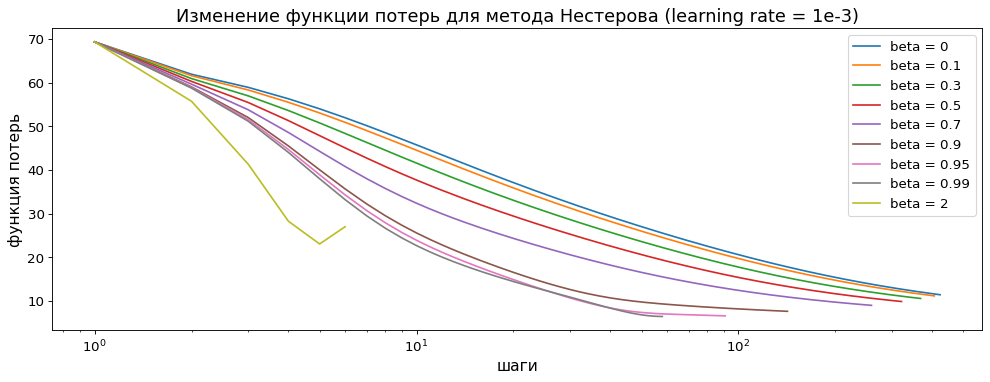

In [11]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для метода Нестерова (learning rate = 1e-3)')
for bt in [0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 2]:
    a_new, gd_losses = gd_nesterov(learning_rate= 1e-3, beta = bt)
    plt.plot(list(range(1, len(gd_losses)+1)), gd_losses, label = 'beta = ' + str(bt))
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

При скорости близкой к оптимальной применение метода Нестерова позволяет ускорить оптимизацию. При низком значении параметра "памяти" результаты становятся близки к результатам обычного градиентного спуска. При слишком большом значении параметра "памяти алгоритм "выпрыгивает" из зоны оптимума.

<ipython-input-5-834b852f1e40>:19: RuntimeWarning: divide by zero encountered in log
  - np.dot((1-y), np.log(1 - logistic_regression(X, a)))


Text(0, 0.5, 'функция потерь')

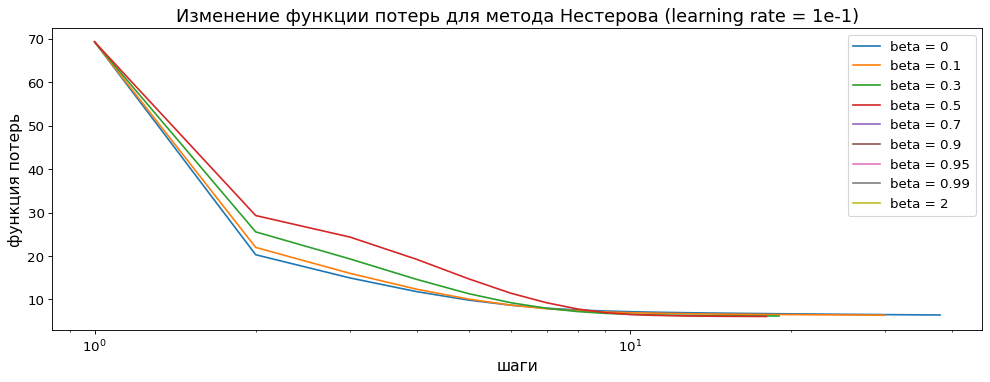

In [12]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для метода Нестерова (learning rate = 1e-1)')
for bt in [0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 2]:
    a_new, gd_losses = gd_nesterov(learning_rate= 1e-1, beta = bt)
    plt.plot(list(range(1, len(gd_losses)+1)), gd_losses, label = 'beta = ' + str(bt))
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

При высоком значении скорости обучения в нашем случае при значении параметра памяти более 0.5 алгоритм "выпрыгивает" из области определения функции потерь.

<ipython-input-5-834b852f1e40>:19: RuntimeWarning: divide by zero encountered in log
  - np.dot((1-y), np.log(1 - logistic_regression(X, a)))


Text(0, 0.5, 'функция потерь')

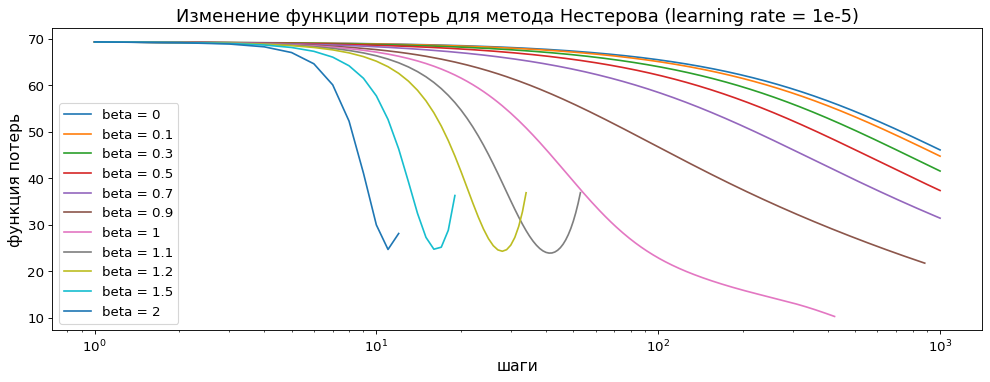

In [13]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для метода Нестерова (learning rate = 1e-5)')
for bt in [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.1, 1.2, 1.5, 2]:
    a_new, gd_losses = gd_nesterov(learning_rate= 1e-5, beta = bt)
    plt.plot(list(range(1, len(gd_losses)+1)), gd_losses, label = 'beta = ' + str(bt))
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

Если выбрано слишком низкое значение скорости обучения, то применение метода Нестерова позволяет выскочить из локального минимума. Однако, даже при очень низкой скорости обучения слишком большое влияние памяти снова может всё испортить.

Использование метода нестерова может помочь побороть проблему локальных минимумов, и ускорить оптимизацию. Однако, важно выбирать правильное соотношение гиперпараметров алгоритма.

### rmsprop

Дополняет метод обычного градиентного спуска с адаптивно изменяемой скоростью обучения.
Гиперпараметры:
    -- начальное значение скорости обучения
    -- коэффициент "памяти" для скорости обучения gama. 0 < gama < 1. чем больше значение gama, тем большее значение на текущую скорость обучения оказывает величина градиента на предыдущих шагах.

In [14]:
def gd_rmsprop(
        a0=a, X=X, y=y, f=sigmoid_loss,
        learning_rate= 0.1,
        grad_delta=1e-12,
        loss_accuracy=0.001,
        gama=0.1
    ):
    # в этот список будем записывать все значения
    # функции потерь для дальнейшего анализа
    losses = []
    # начальное значение функции потерь
    a0_loss = sigmoid_loss(X, y, a0)
    losses.append(a0_loss)
    # переменная для условия цикла по сходимости
    new_loss = a0_loss + loss_accuracy*10
    
    # переменная s учасзтвует в рассчёте скорости обучения
    # сделаем значение s таким, чтобы на первом шаге она не повлияла на скорость обучения 
    grad_vector = gradient(a0=a0, X=X, y=y, f=f)
    s = grad_vector*grad_vector
    
    # переменная для ограничения числа итераций
    steps = 0 
    while abs(a0_loss - new_loss) > loss_accuracy:
        a0_loss = new_loss
        grad_vector = gradient(a0=a0, X=X, y=y, f=f)
        
        # здесь используются данные о величинах градиента на предыдущих шагах
        s = gama*s + (1 - gama)*grad_vector*grad_vector
        # смещаемся в новую точку с адаптивной скоростью
        a0 = a0 - learning_rate*grad_vector / np.sqrt(s + grad_delta)
        new_loss = sigmoid_loss(X, y, a0)
        losses.append(new_loss)
        
        steps += 1
        if steps > 1e4: break
    return a0, losses

a_new, gd_losses = gd_rmsprop()
print('New coefficients: ', a_new)
print('Steps:', len(gd_losses))
print('Loss function value = ', gd_losses[-1])
print('Accuracy_score = ', classifier_score(logistic_classifier(X, a_new), y))
classifier_accuracy_matrix(logistic_classifier(X, a_new), y)

New coefficients:  [-1.33730978 -1.80357469  6.79047205  6.78574409]
Steps: 70
Loss function value =  6.069028899788687
Accuracy_score =  0.97
             right
First_class   [48, 2]
Second class  [49, 1]


Text(0, 0.5, 'функция потерь')

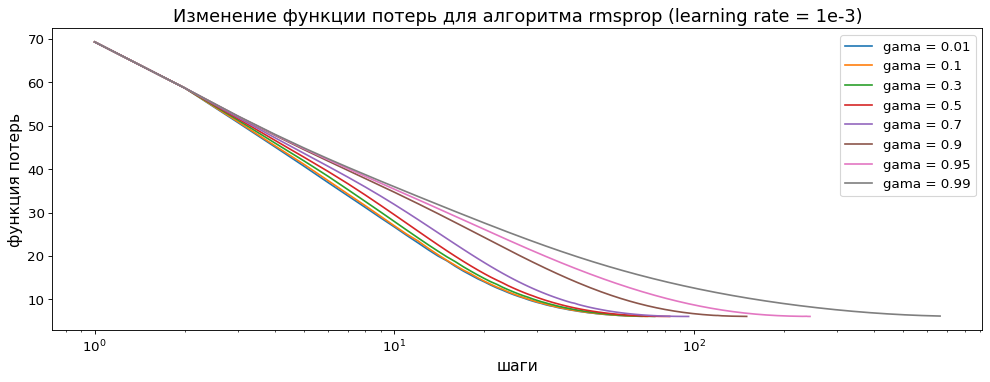

In [15]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для алгоритма rmsprop (learning rate = 1e-3)')
for gm in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]:
    a_new, gd_losses = gd_rmsprop(learning_rate= 1e-1, gama=gm)
    plt.plot(list(range(1, len(gd_losses)+1)), gd_losses, label = 'gama = ' + str(gm))
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

При более низких значениях gama используются более актуальные данные о величине градиента, что ускоряет сходимость.

Text(0, 0.5, 'функция потерь')

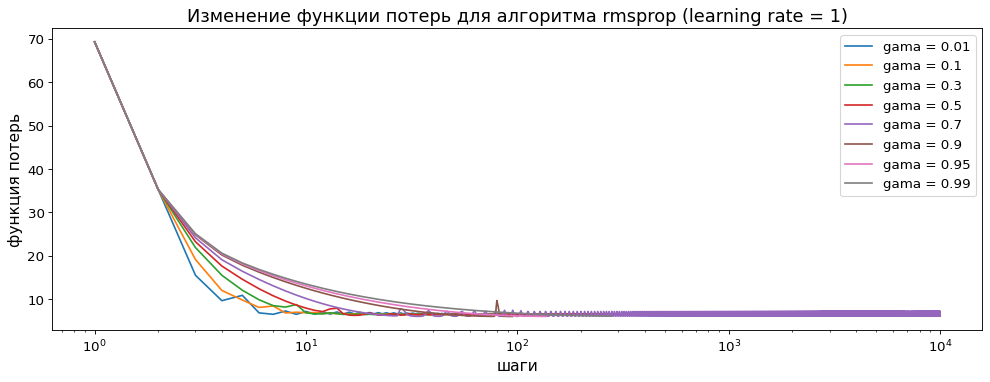

In [16]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для алгоритма rmsprop (learning rate = 1)')
for gm in [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]:
    a_new, gd_losses = gd_rmsprop(learning_rate= 1, gama=gm)
    plt.plot(list(range(1, len(gd_losses)+1)), gd_losses, label = 'gama = ' + str(gm))
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

При выборе для первого шага очень большой величины скорости rmsprop позволяет недопустить "вылет" из области глобального максимума (и из области определения функции) 

Text(0, 0.5, 'функция потерь')

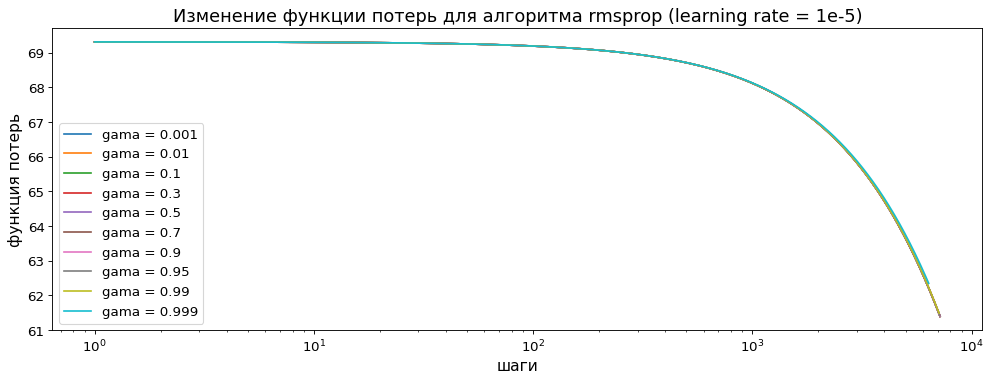

In [17]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для алгоритма rmsprop (learning rate = 1e-5)')
for gm in [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 0.999]:
    a_new, gd_losses = gd_rmsprop(learning_rate= 1e-5, gama=gm)
    plt.plot(list(range(1, len(gd_losses)+1)), gd_losses, label = 'gama = ' + str(gm))
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

Для очень малого значения скорости обучения на первом шаге адаптивность скорости обучения в дальнейшем может не помочь от застревания в локальном минимуме.

Text(0, 0.5, 'функция потерь')

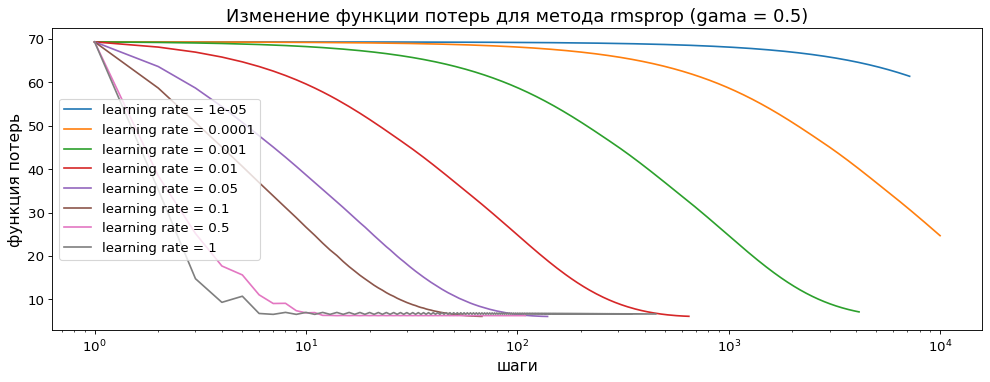

In [18]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для метода rmsprop (gama = 0.5)')
for lr in [1e-5, 1e-4,0.001, 0.01, 0.05, 0.1, 0.5, 1]:
    a_new, gd_losses = gd_rmsprop(learning_rate= lr, gama=0.001)
    plt.plot(list(range(1, len(gd_losses)+1)), gd_losses, label = 'learning rate = ' + str(lr))
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

Для ширкого диапазона начальных значений скорости обучения rmsprop позволяет прийти к оптимальной точке без застревания в локальных минимумах. Также rmsprop может нейтрализовать слишком высокое значение скорости обучения на первом шаге.

### Adam optimizer

Объединяет идеи Nesterom momentum и rmsprop.

beta_1 за использование данных о велечине шагов на предыдущих итерациях.

beta_2 за использование данных о величине градиента на предыдущих шагах.

In [19]:
def gd_adam(a0=a, X=X, y=y, f=sigmoid_loss, 
       grad_delta=1e-12,
       loss_accuracy=0.001,
       learning_rate= 0.01, 
       beta_1=0.1, 
       beta_2=0.01,
       t = 10):

    losses = []
    a0_loss = sigmoid_loss(X, y, a0)
    losses.append(a0_loss)
    
    grad_vector = gradient(a0=a0, X=X, y=y, f=f)
    m = - grad_vector
    s = grad_vector*grad_vector
    
    m_caped = m /(1 - beta_1**t)
    s_caped = s /(1 - beta_2**t)
    
    a0 = a0 + learning_rate * m_caped /np.sqrt(s_caped + grad_delta)
    
    a0_loss = sigmoid_loss(X, y, a0)
    losses.append(a0_loss)

    new_loss = a0_loss + loss_accuracy*10    
    while abs(a0_loss - new_loss) > loss_accuracy:
        grad_vector = gradient(a0=a0, X=X, y=y, f=f)
        
        # учёт величины градиента на предыдущих шагах
        m = beta_1*m - (1 - beta_1)*grad_vector
        # сдвиг в направлении предыдущего шага
        s = beta_2*s + (1 - beta_2)*grad_vector*grad_vector
        
        m_caped = m /(1 - beta_1**t)
        s_caped = s /(1 - beta_2**t)
    
        new_loss = sigmoid_loss(X, y, a0)
        a0 = a0 + learning_rate * m_caped /np.sqrt(s_caped + grad_delta)
        
        a0_loss = new_loss
        new_loss = sigmoid_loss(X, y, a0)
        losses.append(new_loss)
    return a0, losses

a_new, gd_losses = gd_adam()
print('New coefficients: ', a_new)
print('Steps:', len(gd_losses))
print('Loss function value = ', gd_losses[-1])
print('Accuracy_score = ', classifier_score(logistic_classifier(X, a_new), y))
classifier_accuracy_matrix(logistic_classifier(X, a_new), y)

New coefficients:  [-1.37123307 -1.81125723  6.52684261  6.52683065]
Steps: 653
Loss function value =  6.081397922109662
Accuracy_score =  0.97
             right
First_class   [48, 2]
Second class  [49, 1]


<ipython-input-5-834b852f1e40>:19: RuntimeWarning: divide by zero encountered in log
  - np.dot((1-y), np.log(1 - logistic_regression(X, a)))


Text(0, 0.5, 'функция потерь')

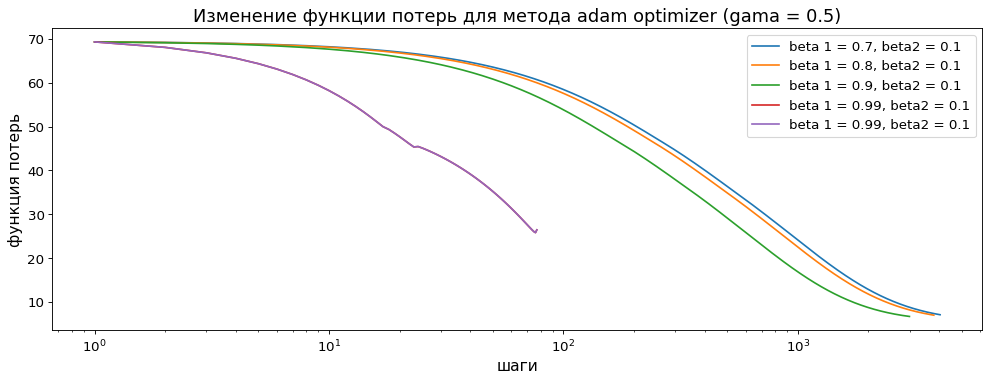

In [20]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для метода adam optimizer (gama = 0.5)')
for b1 in [0.7, 0.8, 0.9, 0.99, 0.99]:
    for b2 in [0.1]:
        a_new, gd_losses = gd_adam(learning_rate= 1e-3, beta_1=b1, beta_2=b2)
        plt.plot(
            list(range(1, len(gd_losses)+1)),
            gd_losses,
            label = 'beta 1 = ' + str(b1) + ', beta2 = ' + str(b2)
        )
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

Text(0, 0.5, 'функция потерь')

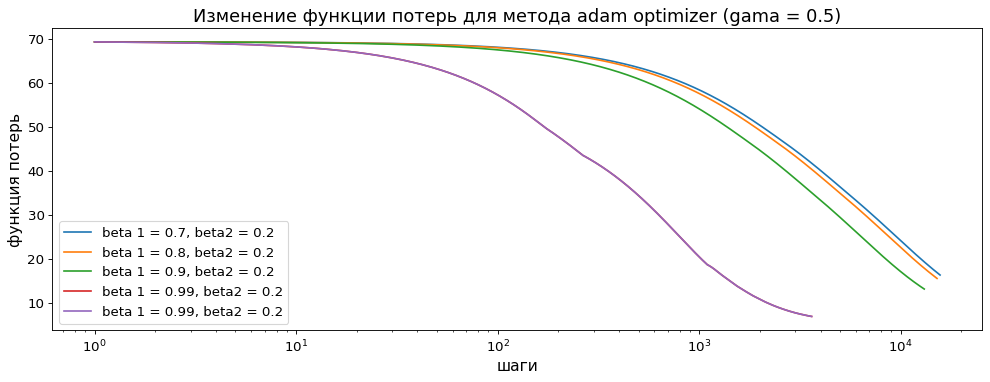

In [21]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для метода adam optimizer (gama = 0.5)')
for b1 in [0.7, 0.8, 0.9, 0.99, 0.99]:
    for b2 in [0.2]:
        a_new, gd_losses = gd_adam(learning_rate= 1e-4, beta_1=b1, beta_2=b2)
        plt.plot(
            list(range(1, len(gd_losses)+1)),
            gd_losses,
            label = 'beta 1 = ' + str(b1) + ', beta2 = ' + str(b2)
        )
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

<ipython-input-5-834b852f1e40>:19: RuntimeWarning: divide by zero encountered in log
  - np.dot((1-y), np.log(1 - logistic_regression(X, a)))


Text(0, 0.5, 'функция потерь')

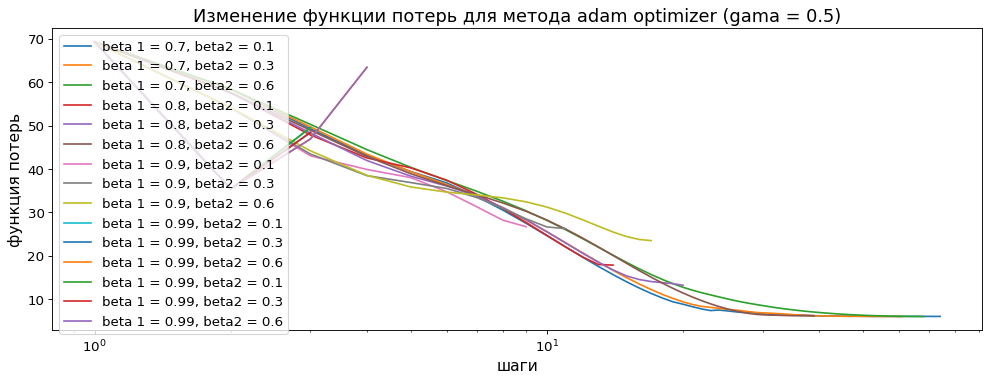

In [22]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для метода adam optimizer (gama = 0.5)')
for b1 in [0.7, 0.8, 0.9, 0.99, 0.99]:
    for b2 in [0.1, 0.3, 0.6]:
        a_new, gd_losses = gd_adam(learning_rate= 0.1, beta_1=b1, beta_2=b2)
        plt.plot(
            list(range(1, len(gd_losses)+1)),
            gd_losses,
            label = 'beta 1 = ' + str(b1) + ', beta2 = ' + str(b2)
        )
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

<ipython-input-5-834b852f1e40>:19: RuntimeWarning: divide by zero encountered in log
  - np.dot((1-y), np.log(1 - logistic_regression(X, a)))


Text(0, 0.5, 'функция потерь')

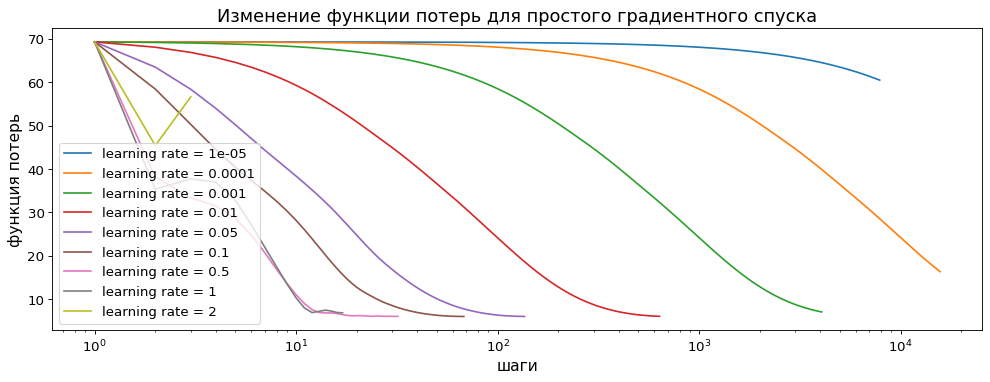

In [23]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для простого градиентного спуска')
for lr in [1e-5, 1e-4,0.001, 0.01, 0.05, 0.1, 0.5, 1, 2]:
    a_new, gd_losses = gd_adam(learning_rate=lr, beta_1=0.7, beta_2=0.6)
    plt.plot(list(range(1, len(gd_losses)+1)), gd_losses, label = 'learning rate = ' + str(lr))
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

<ipython-input-5-834b852f1e40>:19: RuntimeWarning: divide by zero encountered in log
  - np.dot((1-y), np.log(1 - logistic_regression(X, a)))


Text(0, 0.5, 'функция потерь')

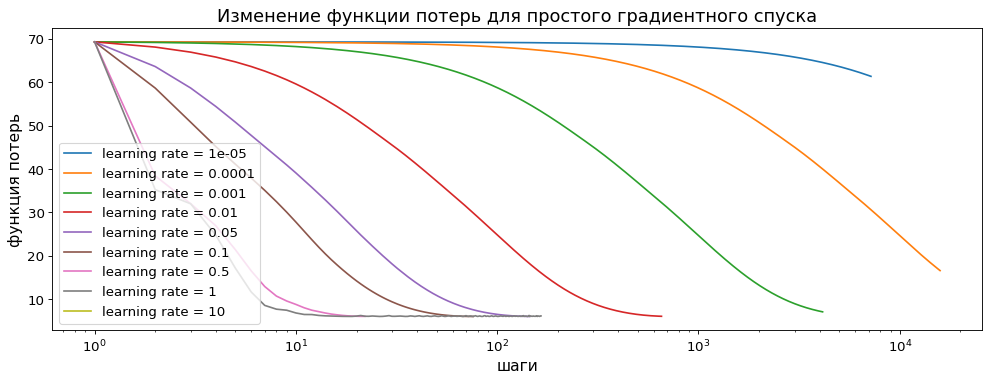

In [24]:
fig = plt.figure(figsize=(15, 5), dpi=80)
plt.title('Изменение функции потерь для простого градиентного спуска')
for lr in [1e-5, 1e-4,0.001, 0.01, 0.05, 0.1, 0.5, 1, 10]:
    a_new, gd_losses = gd_adam(learning_rate=lr, beta_1=0.5, beta_2=0.5)
    plt.plot(list(range(1, len(gd_losses)+1)), gd_losses, label = 'learning rate = ' + str(lr))
plt.legend()
plt.semilogx()
plt.xlabel("шаги")
plt.ylabel("функция потерь")

Adam optimizer использует нечувствительно rmsprop к начальному значению скорости обучения и ускоренную сходимость Nesterom momentum.